In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [3]:
PATH = Path("/home/rob/code/Project/dataset/GTSRB/Training")
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [4]:
_N = 32
batch_size = 128
n_classes = 43
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale()
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = 0
    std = 0
    total = 0
    for images,_ in dataloader: # load a batch at a time
        total += 1
        mean  += images.mean()
        std   += images.std()
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor(0.3211), tensor(0.2230))

In [6]:
mean = 0.3211
std = 0.2230

def to_image(img): # convert to unormalized form for viewing

    return (img * std + mean).permute(1,2,0).numpy()

normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    normalise
])

In [7]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

torch.Size([128, 1, 32, 32])
120 km/h


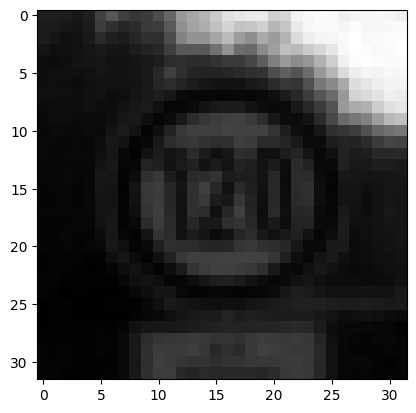

In [8]:
for img,label in train_loader:
    print(img.shape)
    img = to_image(img[0])

    plt.imshow(img,cmap="grey")
    print(LABELS[label[0]])
    break

In [9]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,1,_N,_N))

        self.activation = torch.nn.functional.relu

        self.pool = torch.nn.AvgPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(1,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = Model().to(device)
summary(model,(1,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 6, 28, 28]             156
         AvgPool2d-2           [128, 6, 14, 14]               0
            Conv2d-3          [128, 16, 10, 10]           2,416
         AvgPool2d-4            [128, 16, 5, 5]               0
            Linear-5                 [128, 128]          51,328
            Linear-6                  [128, 64]           8,256
            Linear-7                  [128, 43]           2,795
Total params: 64,951
Trainable params: 64,951
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.50
Forward/backward pass size (MB): 7.92
Params size (MB): 0.25
Estimated Total Size (MB): 8.67
----------------------------------------------------------------


In [10]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [18]:

def train(model,loss_func,optimiser,epochs):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")

def test_performance(model,loss_func):
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss += loss_func(preds,labels).item()
    return loss / len(test_loader)

In [ ]:
train(model,loss_func,optimiser,epochs)

Epoch 1 --- Training Loss 2.101 --- Validation Loss 0.873
Epoch 2 --- Training Loss 0.651 --- Validation Loss 0.675
Epoch 3 --- Training Loss 0.427 --- Validation Loss 0.384
Epoch 4 --- Training Loss 0.313 --- Validation Loss 0.362
Epoch 5 --- Training Loss 0.244 --- Validation Loss 0.245
Epoch 6 --- Training Loss 0.183 --- Validation Loss 0.216
Epoch 7 --- Training Loss 0.150 --- Validation Loss 0.180
Epoch 8 --- Training Loss 0.121 --- Validation Loss 0.172
Epoch 9 --- Training Loss 0.100 --- Validation Loss 0.183
Epoch 10 --- Training Loss 0.099 --- Validation Loss 0.158
Epoch 11 --- Training Loss 0.072 --- Validation Loss 0.155
Epoch 12 --- Training Loss 0.063 --- Validation Loss 0.133
Epoch 13 --- Training Loss 0.055 --- Validation Loss 0.139
Epoch 14 --- Training Loss 0.046 --- Validation Loss 0.132
Epoch 15 --- Training Loss 0.042 --- Validation Loss 0.133
Epoch 16 --- Training Loss 0.035 --- Validation Loss 0.133
Epoch 17 --- Training Loss 0.036 --- Validation Loss 0.147
Epoch 

In [27]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.8798
Recall (macro): 0.8360
F1-score (macro): 0.8454


In [ ]:
@torch.compile
def pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    
    adversarial = denormalise(images)
    lower_bound = adversarial - epsilon
    upper_bound = adversarial + epsilon
    
    decay = torch.logspace(decay_rate,1,iterations,2)
    decay = decay / decay[0]
    decay *= learning_rate
    
    momentum = torch.zeros(images.shape).to(device)

    for alpha in decay:
        normalised = normalise(adversarial)
        normalised.requires_grad = True
        model.zero_grad()
        pred = model(normalised)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(normalised.grad.data)
        
        adversarial += (perturbations + momentum) * alpha

        momentum = momentum * momentum_decay + (1 - momentum_decay) * perturbations

        adversarial = torch.clip(adversarial,lower_bound, upper_bound)
        adversarial = torch.clip(adversarial,0,1)

    return normalise(adversarial)



normalise.to(device)

@torch.compile
def denormalise(images):
    return images * std + mean




In [ ]:
def pgd_grid_search(results):
    epsilon = 10 / 255
    iterations = 40
    decay_rates = [6,7,8,9]#[2.0,3.0,5.0,10.0,15.0]
    learning_rates = [30 / 255,35 / 255,40 / 255]
    betas = [.8]
    
    for decay_rate in decay_rates:
        for learning_rate in learning_rates:
            for beta in betas:
                total_loss = 0
                for img,lbl in train_loader:
                    img, lbl = img.to(device), lbl.to(device)
                    
                    adv = pgd_attack(model,img,lbl,loss_func,epsilon,iterations,decay_rate,learning_rate,beta)
                    pred = model(adv)
                    total_loss += loss_func(pred,lbl).item()
                to_add = (decay_rate,learning_rate,beta,total_loss)
                results.append(to_add)
                print(to_add)
    return results
                
res = []
pgd_grid_search(res)

(6, 0.11764705882352941, 0.8, 10056.962985992432)
(6, 0.13725490196078433, 0.8, 10111.541164398193)
(6, 0.1568627450980392, 0.8, 10132.145086288452)
(7, 0.11764705882352941, 0.8, 10051.76547241211)
(7, 0.13725490196078433, 0.8, 10096.835628509521)
(7, 0.1568627450980392, 0.8, 10124.940227508545)
(8, 0.11764705882352941, 0.8, 10026.613346099854)
(8, 0.13725490196078433, 0.8, 10064.234287261963)
(8, 0.1568627450980392, 0.8, 10128.921215057373)
(9, 0.11764705882352941, 0.8, 9999.634498596191)
(9, 0.13725490196078433, 0.8, 10057.099464416504)
(9, 0.1568627450980392, 0.8, 10092.640487670898)


[(6, 0.11764705882352941, 0.8, 10056.962985992432),
 (6, 0.13725490196078433, 0.8, 10111.541164398193),
 (6, 0.1568627450980392, 0.8, 10132.145086288452),
 (7, 0.11764705882352941, 0.8, 10051.76547241211),
 (7, 0.13725490196078433, 0.8, 10096.835628509521),
 (7, 0.1568627450980392, 0.8, 10124.940227508545),
 (8, 0.11764705882352941, 0.8, 10026.613346099854),
 (8, 0.13725490196078433, 0.8, 10064.234287261963),
 (8, 0.1568627450980392, 0.8, 10128.921215057373),
 (9, 0.11764705882352941, 0.8, 9999.634498596191),
 (9, 0.13725490196078433, 0.8, 10057.099464416504),
 (9, 0.1568627450980392, 0.8, 10092.640487670898)]

In [ ]:
abcd = sorted(res,key=lambda x : x[3],reverse=True)
# Decay rate, learning rate, beta 6, 40.0, 0.8
list(map(lambda x : (x[0],x[1] * 255,*x[2:]),abcd))

[(6, 40.0, 0.8, 10132.145086288452),
 (8, 40.0, 0.8, 10128.921215057373),
 (7, 40.0, 0.8, 10124.940227508545),
 (6, 35.0, 0.8, 10111.541164398193),
 (7, 35.0, 0.8, 10096.835628509521),
 (9, 40.0, 0.8, 10092.640487670898),
 (8, 35.0, 0.8, 10064.234287261963),
 (9, 35.0, 0.8, 10057.099464416504),
 (6, 30.0, 0.8, 10056.962985992432),
 (7, 30.0, 0.8, 10051.76547241211),
 (8, 30.0, 0.8, 10026.613346099854),
 (9, 30.0, 0.8, 9999.634498596191)]

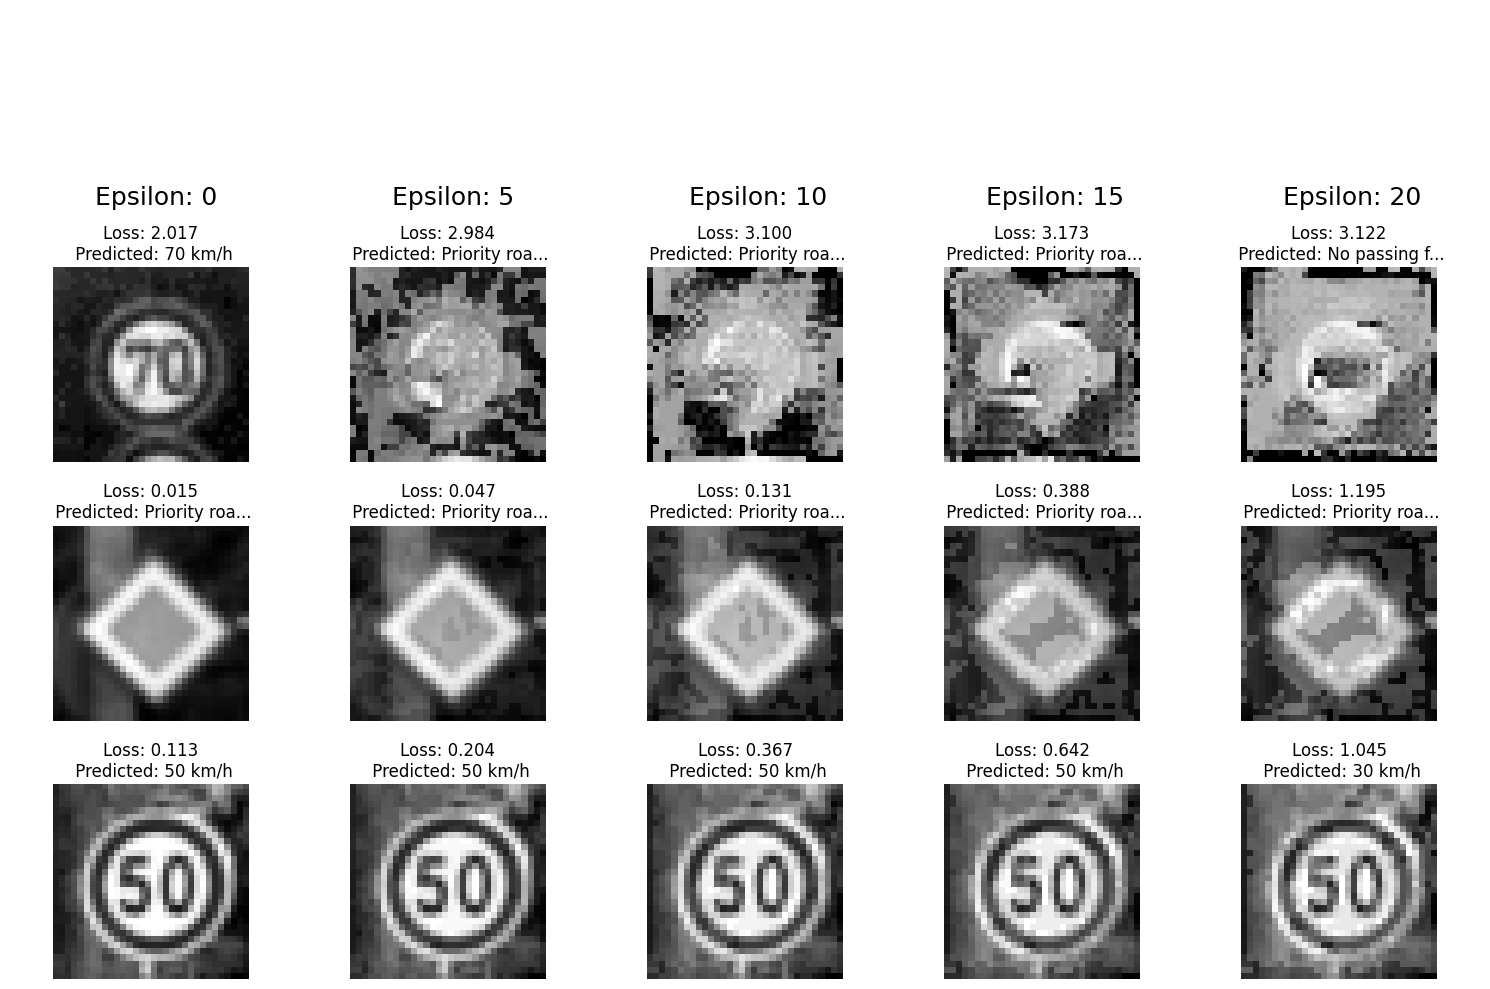

In [35]:
def adversarial_test(model):
    for img,lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        rows = 4
        columns = 5
        decay_rate = 6
        learning_rate = 40 / 255
        momentum_decay = 0.8
        iterations = 40
        epsilon = 0.078
        plt.figure(figsize=(15, 10))
        multiplier = 5
        for j in range(columns):
            epsilon = j * multiplier
            plt.subplot(rows, columns, j + 1)
            plt.axis("off")
            plt.text(0.3, 0, f"Epsilon: {epsilon}", fontsize=18)

            

        for j in range(columns):
            epsilon = j * multiplier / 255
            adv = pgd_attack(model,img,lbl,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
            for i in range(1,rows):
                plt.subplot(rows, columns, i * columns + j + 1)
                pred = model(adv[i].reshape(1,1,_N,_N))
                loss = loss_func(pred,lbl[i].reshape(1)).data
                pred_class = LABELS[torch.argmax(pred)]
                pred_class = pred_class[:12] + "..." if len(pred_class) > 12 else pred_class
                plt.imshow(to_image(adv[i].cpu()),cmap="grey")
                plt.title(f"Loss: {loss:.3f}\n Predicted: {pred_class}")
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        # Gets errors for images being out of 0-1 range, probably floating point inaccuracy
        break
adversarial_test(model)

In [13]:
def adversarial_training(model,loss_func,optimiser,epochs,epsilon,iterations,decay_rate,learning_rate,momentum_decay):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            images = torch.cat((images,
                pgd_attack(model,images,labels,loss_func,epsilon,iterations,decay_rate,learning_rate,momentum_decay)
                ))
            labels = torch.cat((labels,labels))

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")


In [16]:
adversarial_model = Model().to(device)
adversarial_model.load_state_dict(torch.load("models/base_epsilon_0.078.pth",weights_only=True))
adv_optimiser = torch.optim.Adam(adversarial_model.parameters())#torch.optim.SGD(adversarial_model.parameters(),lr=0.01, momentum=0.9)

In [25]:
decay_rate = 6
learning_rate = 40 / 255
momentum_decay = 0.8
iterations = 40
epsilon = 0.078
epochs = 50
adversarial_training(model,loss_func,optimiser,epochs,epsilon,iterations,decay_rate,learning_rate,momentum_decay)

Epoch 1 --- Training Loss 1.904 --- Validation Loss 1.063
Epoch 2 --- Training Loss 1.902 --- Validation Loss 1.049
Epoch 3 --- Training Loss 1.902 --- Validation Loss 1.033
Epoch 4 --- Training Loss 1.900 --- Validation Loss 1.036
Epoch 5 --- Training Loss 1.898 --- Validation Loss 1.044
Epoch 6 --- Training Loss 1.901 --- Validation Loss 1.028
Epoch 7 --- Training Loss 1.895 --- Validation Loss 1.032
Epoch 8 --- Training Loss 1.897 --- Validation Loss 1.028
Epoch 9 --- Training Loss 1.891 --- Validation Loss 1.022
Epoch 10 --- Training Loss 1.885 --- Validation Loss 1.018
Epoch 11 --- Training Loss 1.887 --- Validation Loss 1.015
Epoch 12 --- Training Loss 1.888 --- Validation Loss 1.006
Epoch 13 --- Training Loss 1.882 --- Validation Loss 1.007
Epoch 14 --- Training Loss 1.879 --- Validation Loss 1.015
Epoch 15 --- Training Loss 1.883 --- Validation Loss 1.013
Epoch 16 --- Training Loss 1.879 --- Validation Loss 1.006
Epoch 17 --- Training Loss 1.882 --- Validation Loss 0.997
Epoch 

In [28]:
evaluate(adversarial_model)

Precision (macro): 0.8148
Recall (macro): 0.7090
F1-score (macro): 0.7344


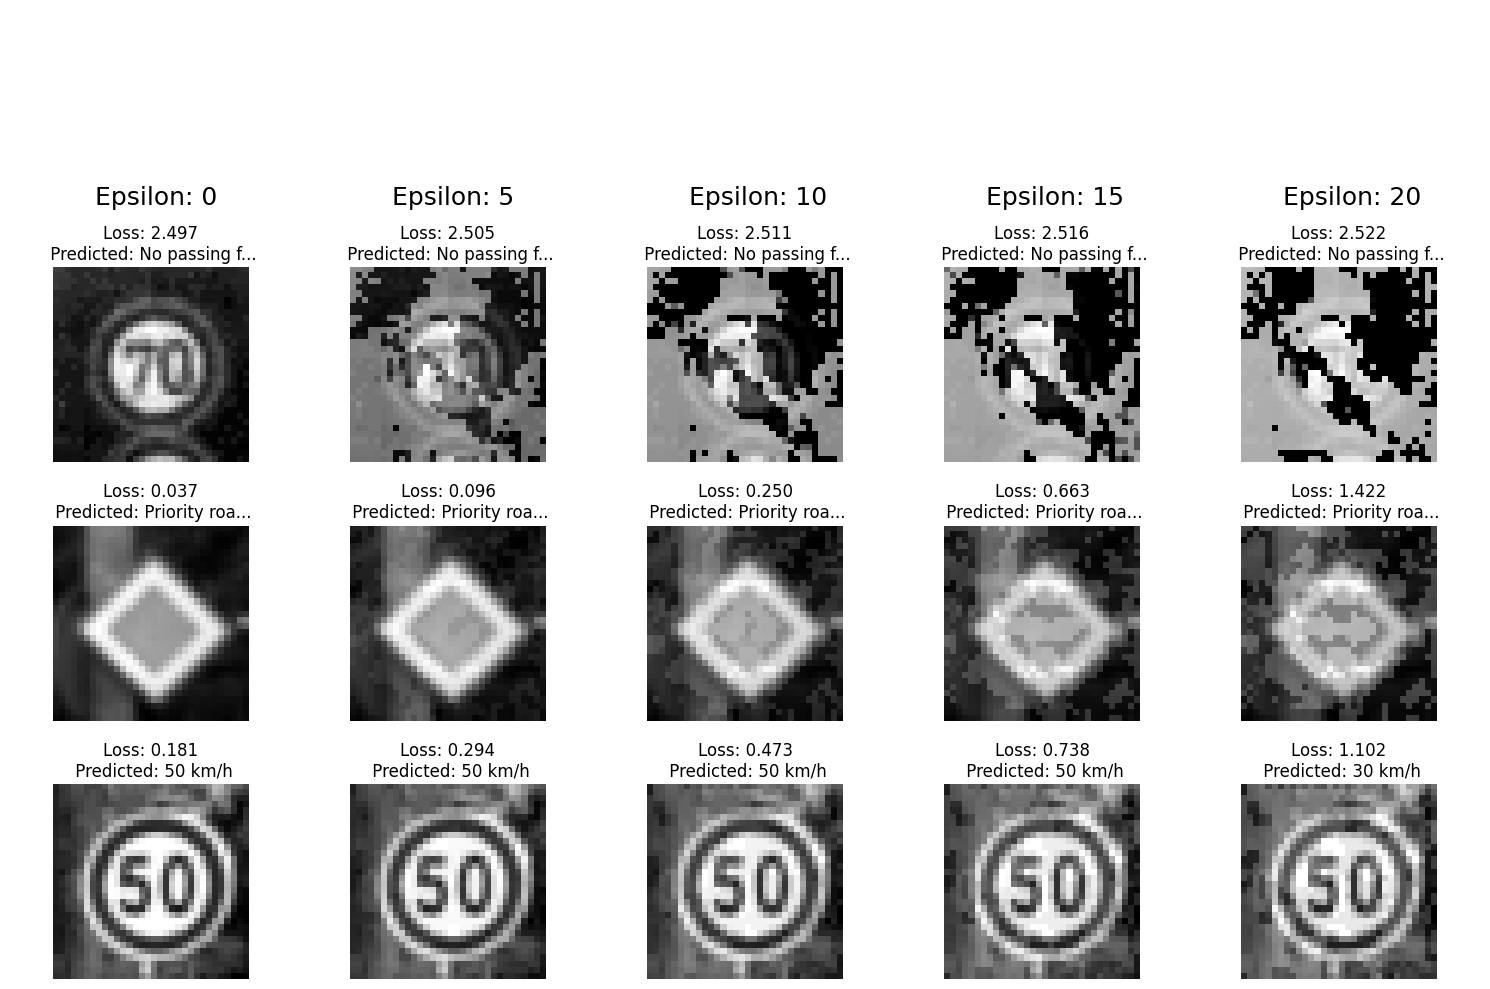

In [31]:
adversarial_test(adversarial_model)

In [78]:
torch.save(adversarial_model.state_dict(),f"models/adversarial_model_grey_{epsilon*255}.pth")